# **FLOW BASED INTRUSION DETECTION ON NSL-KDD DATASET**

## **Environment Setup**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Importing Libraries**

In [2]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import imblearn
import sklearn
%matplotlib inline

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## **Load Data**
Datasets with 3 different CSV files, each contains same type of attack data at different times.

In [3]:
features = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
          'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
          'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
          'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
          'num_access_files', 'num_outbound_cmds', 'is_host_login',
          'is_guest_login', 'count', 'srv_count', 'serror_rate',
          'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
          'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
          'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
          'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
          'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
          'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level']

In [4]:
# Load NSL_KDDTrain dataset
kddTrain = pd.read_csv('/content/drive/MyDrive/2117493_PROJECT/NIDS/NSL-KDD/Datasets/KDDTrain+.txt', names=features)

# Load NSL_KDDTest dataset
kddTest = pd.read_csv('/content/drive/MyDrive/2117493_PROJECT/NIDS/NSL-KDD/Datasets/KDDTest+.txt', names=features)

kddTrain.shape, kddTest.shape

((125973, 43), (22544, 43))

In [5]:
# Combining all tables into one dataset. This is possilbe since all tables have the same columns,
# as we checked in the cell above.
combinedData = pd.concat([kddTrain, kddTest]).drop_duplicates(keep=False)
combinedData.reset_index(drop=True, inplace = True)

In [6]:
print('Data has {} rows & {} columns'.format(combinedData.shape[0],combinedData.shape[1]))

Data has 147297 rows & 43 columns


In [7]:
combinedData.tail(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
147294,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
147295,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
147296,0,tcp,sunrpc,REJ,0,0,0,0,0,0,...,0.08,0.03,0.00,0.00,0.00,0.0,0.44,1.00,mscan,14


In [8]:
combinedData.dtypes.value_counts()

int64      24
float64    15
object      4
dtype: int64

Some general info about the dataset. It contains roughly 148517 rows across 43 columns. Data consists of mostly int64 and float64 types, except 4 attributes of 'object' type.

## **Data Cleaning**
This section contains data cleaning code. We go through the process of renaming columns, removing NaN to get the data ready for visualization and model training.

### Renaming columns

In [9]:
# Removing whitespaces in column names.
attacks = [col.replace(' ', '') for col in combinedData.columns]
combinedData.columns = attacks

In [10]:
# lets see that 'subclass' column contains some wierd characters. 
combinedData["attack_type"].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl', 'saint', 'mscan', 'apache2',
       'snmpgetattack', 'processtable', 'httptunnel', 'ps', 'snmpguess',
       'mailbomb', 'named', 'sendmail', 'xterm', 'worm', 'xlock',
       'xsnoop', 'sqlattack', 'udpstorm'], dtype=object)

### Removing NULL values

In [11]:
# Checking if there are any NULL values in the dataset.
combinedData.isnull().values.any()

False

In [12]:
# Checking which column/s contain NULL values.
[col for col in combinedData if combinedData[col].isnull().values.any()]

[]

In [13]:
# since num_outbound_cmds is a redundant colums, so remove it from dataset
print(combinedData['num_outbound_cmds'].value_counts())
combinedData.drop(['num_outbound_cmds'], axis=1, inplace=True)
combinedData.drop(['difficulty_level'], axis=1, inplace=True)

0    147297
Name: num_outbound_cmds, dtype: int64


In [14]:
combinedData.isnull().any().any()

False

## **Data Visualization**

**Flow Intrusion Detection**

In [15]:
# changing attack labels into two categories 'normal' and 'anomaly'
flow_label = pd.DataFrame(combinedData.attack_type.map(lambda x:'normal' if x=='normal' else 'anomaly'))

In [16]:
# creating a dataframe with binary labels (normal,anomaly)
flow_data = combinedData.copy()
flow_data['label'] = flow_label

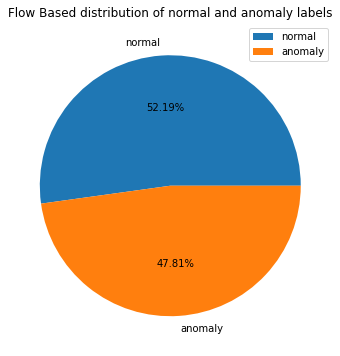

In [17]:
# pie chart distribution of normal and anomaly labels
plt.figure(figsize=(6,6))
plt.pie(flow_data.label.value_counts(),labels=flow_data.label.unique(),autopct='%0.2f%%')
plt.title("Flow Based distribution of normal and anomaly labels")
plt.legend()
plt.savefig('/content/drive/MyDrive/2117493_PROJECT/NIDS/NSL-KDD/Images/Pie_chart_binary.png')
plt.show()

In [18]:
for i in range(len(combinedData['attack_type'])):
      if combinedData['attack_type'][i] != 'normal':
        combinedData['attack_type'][i] = 'anomaly'

combinedData['attack_type'].value_counts()

normal     76880
anomaly    70417
Name: attack_type, dtype: int64

In [19]:
# creating a dataframe with flow-based labels (Dos,Probe,R2L,U2R,normal)
flow_data = combinedData.copy()
flow_label = pd.DataFrame(flow_data.attack_type)

In [20]:
# label encoding (0,1) flow-based labels (anomaly and normal)
le1 = preprocessing.LabelEncoder()
enc_label = flow_label.apply(le1.fit_transform)
flow_data['intrusion'] = enc_label

In [21]:
np.save("/content/drive/MyDrive/2117493_PROJECT/NIDS/NSL-KDD/Labels",le1.classes_,allow_pickle=True)

## **Encoding Categorical Attributes**

Separating Features and target for Model training

In [22]:
XX = combinedData.iloc[:,:-1].values
YY = combinedData.iloc[:,-1].values
YY = YY.reshape(-1,1)
print([XX.shape, YY.shape])
YY

[(147297, 40), (147297, 1)]


array([['normal'],
       ['normal'],
       ['anomaly'],
       ...,
       ['normal'],
       ['anomaly'],
       ['anomaly']], dtype=object)

Visualizing string features

In [23]:
combinedData.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [24]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoder = LabelEncoder()
ohe = OneHotEncoder()

XX[:,1] = encoder.fit_transform(XX[:,1])
XX[:,2] = encoder.fit_transform(XX[:,2])
XX[:,3] = encoder.fit_transform(XX[:,3])

yy = encoder.fit_transform(YY).reshape(-1,1)
YY = ohe.fit_transform(yy).toarray()
XX.shape, YY.shape
YY

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [25]:
combinedData.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type'],
      dtype='object')

In [26]:
cols_ = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

In [27]:
dataX = pd.DataFrame(XX,columns=cols_)
dataY = pd.DataFrame(yy)
dataY

,0
0,1
1,1
2,0
3,1
4,1
...,...
147292,0
147293,1
147294,1
147295,0


## **Feature Selection**
Since there is such a large number of features, it is possible that some features are redundant. 

In [28]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import itertools    

model_ = DecisionTreeClassifier()

# create RFE model and select 15 attributes
rec = RFE(model_, n_features_to_select = 15)
rec = rec.fit(dataX, dataY)

# summarize the selection of the attributes
featuresMap = [(x, n) for x, n in itertools.zip_longest(rec.get_support(), dataX.columns)]
selectedFeatures = [n for x, n in featuresMap if x == True]

print(selectedFeatures)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate']


Selecting Features

In [29]:
dataX = dataX[selectedFeatures]
X = dataX[selectedFeatures]
print('15 selected features \n')
X.head()

15 selected features 



,duration,protocol_type,service,flag,src_bytes,dst_bytes,hot,num_failed_logins,count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,dst_host_rerror_rate
0,0,1,20,9,491,0,0,0,2,25,0.17,0.17,0.0,0.0,0.05
1,0,2,44,9,146,0,0,0,13,1,0.0,0.88,0.0,0.0,0.0
2,0,1,49,5,0,0,0,0,123,26,0.1,0.0,0.0,1.0,0.0
3,0,1,24,9,232,8153,0,0,5,255,1.0,0.03,0.04,0.01,0.0
4,0,1,24,9,199,420,0,0,30,255,1.0,0.0,0.0,0.0,0.0


## **Dataset Splitting**
The next step is to split training and testing data. For this we will use sklearn function train_test_split(). This step is important so we can have representative data for evaluating our model. Both train and test samples should contain similar data variance.

In [31]:
# The next step is to split training and testing data. For this we will use sklearn function train_test_split().
from sklearn.model_selection import train_test_split
i_train, i_test, j_train, j_test = train_test_split(dataX, dataY, train_size=0.7,test_size=0.3,  random_state = 1, shuffle=True)

In [32]:
i_train.shape, j_train.shape, i_test.shape, j_test.shape    # test is larger... good 

((103107, 15), (103107, 1), (44190, 15), (44190, 1))

## **Scaling Numerical Attributes**
The next few cells contain the code for scaling the data into the size adequate for the Models.

In [33]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
i_train = sc.fit_transform(i_train)
i_test = sc.transform(i_test)
i_train.shape, i_test.shape

((103107, 15), (44190, 15))

## **Machine-Learning model training**

importing required libraries for ml model

In [34]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error,roc_auc_score,cohen_kappa_score)
import sklearn.metrics as metrics

### Training four base learners: decision tree, random forest, XGBoost

#### Apply DT

Training Decision Tree

Accuracy of Decision Tree: 0.9937995021498076
              precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99     21189
      normal       0.99      0.99      0.99     23001

    accuracy                           0.99     44190
   macro avg       0.99      0.99      0.99     44190
weighted avg       0.99      0.99      0.99     44190



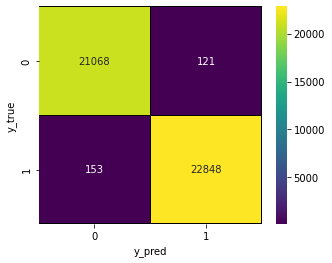

In [35]:
##@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(i_train, j_train) 

y_predict=dt.predict(i_test)
y_true=j_test

dt_score=dt.score(i_test, j_test)
print('Accuracy of Decision Tree: '+ str(dt_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names=le1.classes_))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,4))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Apply RF

Training Random Forest

Accuracy of Random Forest: 0.9955646073772346
              precision    recall  f1-score   support

     anomaly       1.00      0.99      1.00     21189
      normal       1.00      1.00      1.00     23001

    accuracy                           1.00     44190
   macro avg       1.00      1.00      1.00     44190
weighted avg       1.00      1.00      1.00     44190



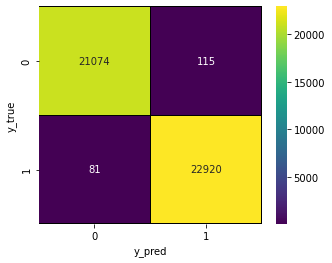

In [36]:
##@title  { vertical-output: true, display-mode: "both" }
rf = RandomForestClassifier(random_state = 0)
rf.fit(i_train, j_train) 

y_predict=rf.predict(i_test)
y_true=j_test

rf_score=rf.score(i_test, j_test)
print('Accuracy of Random Forest: '+ str(rf_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names=le1.classes_))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,4))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Apply XGBoost

Training XGBoost

Accuracy of Gradient Boosting: 0.9564607377234668
              precision    recall  f1-score   support

     anomaly       0.96      0.95      0.95     21189
      normal       0.96      0.96      0.96     23001

    accuracy                           0.96     44190
   macro avg       0.96      0.96      0.96     44190
weighted avg       0.96      0.96      0.96     44190



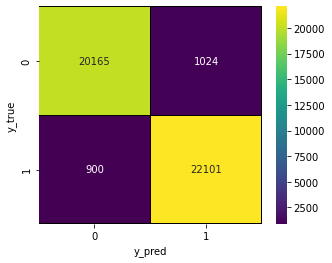

In [37]:
##@title  { vertical-output: true, display-mode: "both" }
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(i_train,j_train)

y_predict=xg.predict(i_test)
y_true=j_test

xg_score=xg.score(i_test, j_test)
print('Accuracy of Gradient Boosting: '+ str(xg_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names=le1.classes_))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,4))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## **Deep-Learning Model Training**
In this stage we go by explaning parts of the network and its hyperparameters.

### Bi-directional LSTM Model


In [38]:
#importing lobraries
import keras
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense,Dropout, BatchNormalization, Activation, Bidirectional, LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from IPython.core.display import Image

In [39]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, YY,  train_size=0.7, test_size=0.3,  random_state = 1, shuffle=True)
print([Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape])

[(103107, 15), (44190, 15), (103107, 2), (44190, 2)]


In [40]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)
Xtrain.shape, Xtest.shape

((103107, 15), (44190, 15))

### Reshaping our data into 3D, which is required format of LSTM input

In [41]:
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1], 1)
Xtrain.shape, Xtest.shape

((103107, 15, 1), (44190, 15, 1))

### Structure of our BiLSTM

In [42]:
timesteps = 60

In [43]:
blstm_model = tf.keras.Sequential()
blstm_model.add(Bidirectional(LSTM(60, return_sequences=True, activation= 'relu', input_shape=(Xtrain.shape[1], timesteps, 1))))
blstm_model.add(Bidirectional(LSTM(60,return_sequences= False, activation= 'relu')))
blstm_model.add(tf.keras.layers.Dropout(0.2))
blstm_model.add(Dense(2, activation= 'softmax'))
blstm_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
history2 = blstm_model.fit(Xtrain, Ytrain,  epochs=10, validation_split=0.3, batch_size=700).history
#model.summary()

Epoch 1/10
104/104 [==============================] - 36s 302ms/step - loss: 0.4446 - accuracy: 0.8248 - val_loss: 0.2708 - val_accuracy: 0.8963
Epoch 2/10
104/104 [==============================] - 31s 299ms/step - loss: 0.2139 - accuracy: 0.9196 - val_loss: 0.1457 - val_accuracy: 0.9405
Epoch 3/10
104/104 [==============================] - 32s 313ms/step - loss: 0.1429 - accuracy: 0.9404 - val_loss: 0.1209 - val_accuracy: 0.9459
Epoch 4/10
104/104 [==============================] - 31s 296ms/step - loss: 0.1277 - accuracy: 0.9483 - val_loss: 0.2130 - val_accuracy: 0.9250
Epoch 5/10
104/104 [==============================] - 30s 293ms/step - loss: 0.1268 - accuracy: 0.9493 - val_loss: 0.1308 - val_accuracy: 0.9469
Epoch 6/10
104/104 [==============================] - 32s 309ms/step - loss: 0.1199 - accuracy: 0.9517 - val_loss: 0.1054 - val_accuracy: 0.9546
Epoch 7/10
104/104 [==============================] - 30s 294ms/step - loss: 0.1045 - accuracy: 0.9585 - val_loss: 0.1024 - val_ac

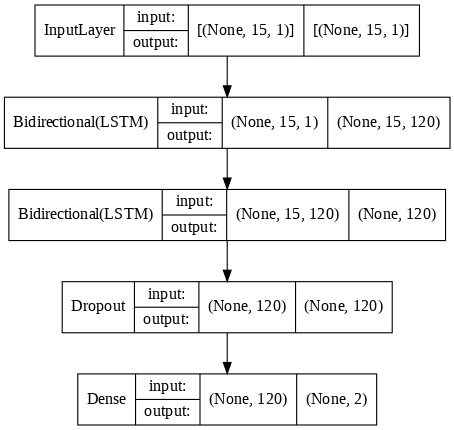

In [44]:
plot_model(blstm_model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

Evaluating our trained BiLSTM

1381/1381 [==============================] - 10s 7ms/step - loss: 0.0921 - accuracy: 0.9628
Accuracy of BLSTM: 0.9627517461776733
              precision    recall  f1-score   support

     anomaly       0.98      0.94      0.96     21189
      normal       0.95      0.98      0.96     23001

    accuracy                           0.96     44190
   macro avg       0.96      0.96      0.96     44190
weighted avg       0.96      0.96      0.96     44190



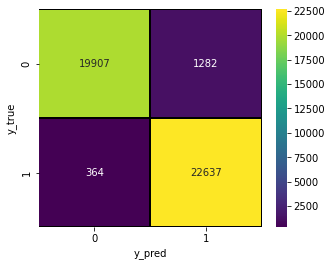

In [45]:
##@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
#We now predict the output for our test dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0
blstm_score = blstm_model.evaluate(Xtest, Ytest)
y_pred=blstm_model.predict(Xtest)
b_predict=np.argmax(y_pred, axis=1)
b_test=np.argmax(Ytest, axis=1)

print('Accuracy of BLSTM: '+ str(blstm_score[1]))
print(metrics.classification_report(b_test, np.round(b_predict), target_names=le1.classes_))

cm=confusion_matrix(b_test, b_predict)
f,ax=plt.subplots(figsize=(5,4))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Accuracy Curve of our trained BiLSTM

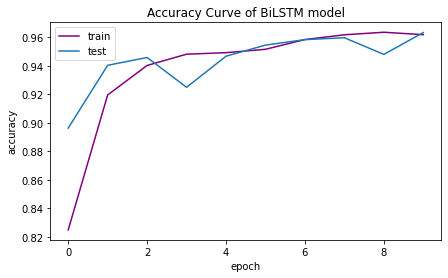

In [46]:
#@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
# Plot of accuracy vs epoch of train and test dataset

plt.figure(figsize=(7,4))
plt.plot(history2['accuracy'], 'purple')
plt.plot(history2['val_accuracy'],'')

plt.title('Accuracy Curve of BiLSTM model')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(['train', 'test'], loc='upper left');

### Loss Curve of our trained BiLSTM

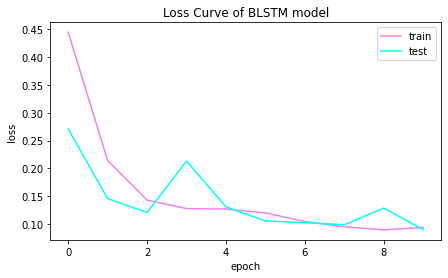

In [47]:
#@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
# Plot of loss vs epoch of train and test dataset

plt.figure(figsize=(7,4))
plt.plot(history2['loss'], 'violet')
plt.plot(history2['val_loss'], 'cyan')

plt.title('Loss Curve of BLSTM model')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(['train', 'test'], loc='upper right');

## **Models Comparision**
The table below tabulates all the score accuracies from each model for a clear comparision.

In [48]:
result = pd.DataFrame({ 'Classifiers': ['DecisionTree Classifier', 'RandomForest Classifier','GradientBoosting Classifier', 'Bidirectional LSTM'],
                         'Score': [dt_score, rf_score, xg_score, blstm_score[1]]})

result

,Classifiers,Score
0,DecisionTree Classifier,0.993800
1,RandomForest Classifier,0.995565
2,GradientBoosting Classifier,0.956461
3,Bidirectional LSTM,0.962752


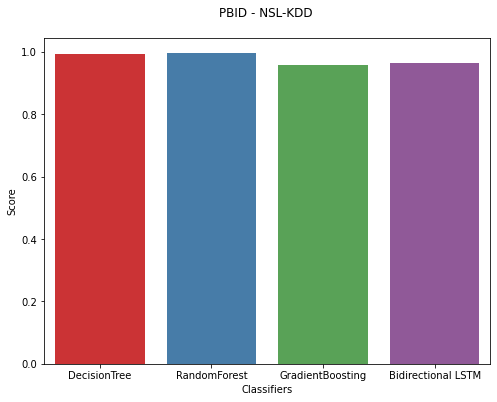

In [49]:
chart = pd.DataFrame({ 'Classifiers': ['DecisionTree', 'RandomForest','GradientBoosting', 'Bidirectional LSTM'],
                         'Score': [dt_score, rf_score, xg_score, blstm_score[1]]})
plt.figure(figsize=(8,6))
ax=sns.barplot(data = chart, x = 'Classifiers', y = 'Score', palette='Set1')
ax.set_xticklabels(ax.get_xticklabels(), )
plt.title('PBID - NSL-KDD \n ', fontsize=12)
#plt.legend([],[], frameon=True)
plt.show()

From these tested models, the results table shows that Random Forest classifier boast a 99% accuracy. 
The Deep Learning Model IS even not far behind which had 95% around for  BLSTM.

In conclusion, the Random Forest classifier performs Very well on comparing with all the models in detecting intrusion on the network. DecisionTree classifier are a close second in detecting intrusions and giving reliable predictions.

Finally To evaluate more about these models, the ROC curve and Calibration plots for multi-class classification need to be implemented thats done in second stage of this study.